In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(84).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(44).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(245).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/6.jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(238).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(196).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(108).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(310).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image (5).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(186).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(29).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(140).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(224).jpg

In [2]:
train_dir="../input/brain-tumor-classification-mri/Training"
test_dir="../input/brain-tumor-classification-mri/Testing"


In [3]:
import cv2
import os
# Image preprocessing For No Tumor
no_tumor_dir="../input/brain-tumor-classification-mri/Training/no_tumor"
images=[x for x in os.listdir(no_tumor_dir)]
for i in images:
    img=cv2.imread(no_tumor_dir+"/"+i)
    scale_percent = 60 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    cv2.imwrite(no_tumor_dir+"/"+"aug"+i,resized)
    
    
    

In [4]:
from keras.preprocessing.image import ImageDataGenerator
trainDataGen=ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,
    zoom_range=0.2,
    
    
)
testDataGen=ImageDataGenerator(rescale=1./255)

trainGen=trainDataGen.flow_from_directory(train_dir,
                                          target_size=(224,224),
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          batch_size=128,
                                          subset='training'
                                         )
testGen=testDataGen.flow_from_directory(test_dir, target_size=(224,224),color_mode='rgb',class_mode='categorical',batch_size=1)

valGen=trainDataGen.flow_from_directory(train_dir, target_size=(224,224),color_mode='rgb',class_mode='categorical',batch_size=128,subset='validation')




Found 2585 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Found 285 images belonging to 4 classes.


In [17]:
from keras.models import Model
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D,Input,AveragePooling2D
from keras.applications.vgg16 import VGG16

base_model=VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')

x=Flatten()(base_model.output)
x=Dense(1024,activation='relu')(x)
x=Dropout(0.4)(x)
x=Dense(1024,activation='relu')(x)
out=Dense(4,activation='softmax')(x)

model=Model(inputs=base_model.inputs,outputs=out)
for layer in model.layers[:22]:
  layer.trainable=False

for layer in model.layers:
  print(layer.name," ",layer.trainable)
model.summary()


input_2   False
block1_conv1   False
block1_conv2   False
block1_pool   False
block2_conv1   False
block2_conv2   False
block2_pool   False
block3_conv1   False
block3_conv2   False
block3_conv3   False
block3_pool   False
block4_conv1   False
block4_conv2   False
block4_conv3   False
block4_pool   False
block5_conv1   False
block5_conv2   False
block5_conv3   False
block5_pool   False
flatten_1   False
dense_3   False
dropout_1   False
dense_4   True
dense_5   True
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
__________________________________________________

In [30]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks=[EarlyStopping(monitor='val_loss',patience=10), ModelCheckpoint(filepath="best_model.h5",monitor='val_loss',save_best_only=True)]


model.compile(loss="categorical_crossentropy",optimizer="Adam",metrics=["accuracy"])

In [31]:
steps_per_epochs=trainGen.samples//128
print(steps_per_epochs)
validation_steps_=valGen.samples//128
print(validation_steps_)


20
2


In [20]:
history=model.fit(trainGen,steps_per_epoch=steps_per_epochs,validation_data=valGen,epochs=50,validation_steps=validation_steps_,callbacks=callbacks)

Epoch 1/50
20/20 [==============================] - 41s 2s/step - loss: 1.3939 - accuracy: 0.4318 - val_loss: 1.1951 - val_accuracy: 0.3945

Epoch 00001: val_loss improved from inf to 1.19507, saving model to best_model.h5


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f80ca0c6050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Epoch 2/50
20/20 [==============================] - 39s 2s/step - loss: 0.9435 - accuracy: 0.6105 - val_loss: 0.9037 - val_accuracy: 0.5703

Epoch 00002: val_loss improved from 1.19507 to 0.90373, saving model to best_model.h5
Epoch 3/50
20/20 [==============================] - 39s 2s/step - loss: 0.8148 - accuracy: 0.6650 - val_loss: 0.8372 - val_accuracy: 0.6328

Epoch 00003: val_loss improved from 0.90373 to 0.83717, saving model to best_model.h5
Epoch 4/50
20/20 [==============================] - 39s 2s/step - loss: 0.7316 - accuracy: 0.7131 - val_loss: 0.7564 - val_accuracy: 0.6758

Epoch 00004: val_loss improved from 0.83717 to 0.75642, saving model to best_model.h5
Epoch 5/50
20/20 [==============================] - 40s 2s/step - loss: 0.6947 - accuracy: 0.7171 - val_loss: 0.7277 - val_accuracy: 0.6797

Epoch 00005: val_loss improved from 0.75642 to 0.72768, saving model to best_model.h5
Epoch 6/50
20/20 [==============================] - 39s 2s/step - loss: 0.7257 - accuracy: 0

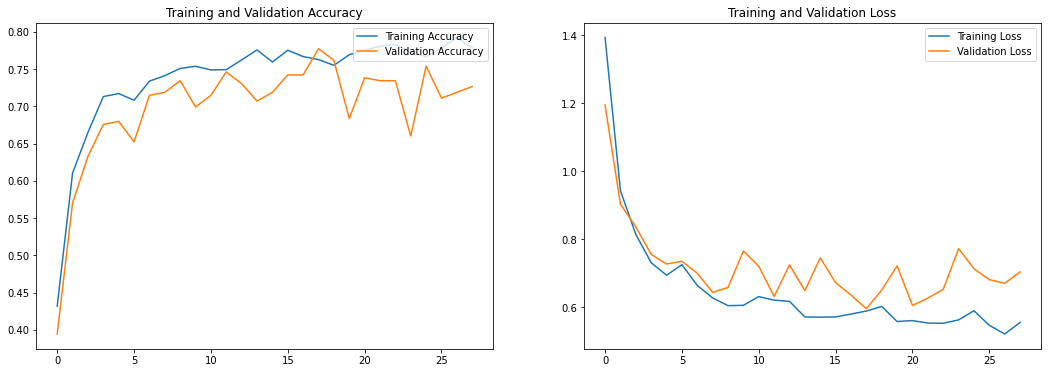

In [32]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(history.history['accuracy'])), acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()